# 从零开始实现

包括数据流水线、模型、损失函数、小批量随机梯度下降优化器

In [1]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

将根据带有噪声的线性模型构造一个人造数据集。 

我们的任务是使用这个有限样本的数据集来恢复这个模型的参数。

 我们将使用低维数据，这样可以很容易地将其可视化。 
 
 在下面的代码中，我们生成一个包含1000个样本的数据集， 每个样本包含从标准正态分布中采样的2个特征。
 
  我们的合成数据集是一个矩阵X

我们使用线性模型参数
W=[2,-3.4]<SUP>T</SUP>,B=4.2和噪声项生成数据集及其标签

In [2]:
def synthetic_data(w, b, num_examples):  #@save
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [3]:
#features中的每一行都包含一个二维数据样本，
# labels中的每一行都包含一维标签值（一个标量）。
print('features:', features[0],'\nlabel:', labels[0])


features: tensor([2.6709, 0.4034]) 
label: tensor([8.1693])


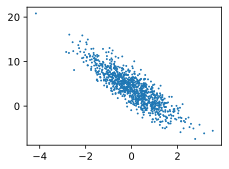

In [ ]:
#通过生成第二个特征features[:, 1]和labels的散点图，
# 可以直观观察到两者之间的线性关系。
d2l.set_figsize()
d2l.plt.scatter(features[:, 1].detach().numpy(), 
                labels.detach().numpy(), 1);

### 读取数据

训练模型时要对数据集进行遍历，每次抽取一小批量样本，并使用它们来更新我们的模型

有必要定义一个函数， 该函数能打乱数据集中的样本并以小批量方式获取数据。

定义一个data_iter函数， 该函数接收批量大小、特征矩阵和标签向量作为输入，生成大小为batch_size的小批量。 每个小批量包含一组特征和标签。


In [5]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [6]:
#直观感受一下小批量运算：读取第一个小批量数据样本并打印。 
# 每个批量的特征维度显示批量大小和输入特征数。
# 同样的，批量的标签形状与batch_size相等
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 1.4046,  0.6530],
        [-2.3808,  0.8887],
        [-0.6821,  0.5714],
        [-0.0056, -0.2847],
        [ 0.4622, -0.3760],
        [-0.4646,  0.2592],
        [ 1.0373,  0.3179],
        [ 1.9088,  0.5514],
        [-1.7152,  0.4637],
        [-0.7944, -0.1684]]) 
 tensor([[ 4.7810],
        [-3.5708],
        [ 0.8971],
        [ 5.1656],
        [ 6.3938],
        [ 2.3843],
        [ 5.1932],
        [ 6.1406],
        [-0.7987],
        [ 3.1786]])


### 初始化模型参数

从均值为0、标准差为0.01的正态分布中采样随机数来初始化权重， 并将偏置初始化为0。


In [7]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

在初始化参数之后，我们的任务是更新这些参数，直到这些参数足够拟合我们的数据。 

每次更新都需要计算损失函数关于模型参数的梯度。 

有了这个梯度，我们就可以向减小损失的方向更新每个参数。

#### 定义模型

 回想一下，要计算线性模型的输出， 我们只需计算输入特征X和模型权重w的矩阵-向量乘法后加上偏置b。
 
  注意，上面的Xw是一个向量，而b是一个标量。 
  
  回想一下 2.1.3节中描述的广播机制： 当我们用一个向量加一个标量时，标量会被加到向量的每个分量上。

In [8]:
def linreg(X, w, b):  #@save
    """线性回归模型"""
    return torch.matmul(X, w) + b

### 定义损失函数

因为需要计算损失函数的梯度，所以我们应该先定义损失函数。

 这里我们使用 3.1节中描述的平方损失函数。 
 
 在实现中，我们需要将真实值y的形状转换为和预测值y_hat的形状相同。

In [9]:
def squared_loss(y_hat, y):  #@save
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

### 定义优化算法

在每一步中，使用从数据集中随机抽取的一个小批量，然后根据参数计算损失的梯度。

 接下来，朝着减少损失的方向更新我们的参数。 
 
 下面的函数实现小批量随机梯度下降更新。 
 
 该函数接受模型参数集合、学习速率和批量大小作为输入。
 
 每一步更新的大小由学习速率lr决定。
 
  因为我们计算的损失是一个批量样本的总和，所以我们用批量大小（batch_size） 来规范化步长，这样步长大小就不会取决于我们对批量大小的选择。

In [10]:
def sgd(params, lr, batch_size):  #@save
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

### 训练
 在每次迭代中，我们读取一小批量训练样本，并通过我们的模型来获得一组预测。 
 
 计算完损失后，我们开始反向传播，存储每个参数的梯度。
 
  最后，我们调用优化算法sgd来更新模型参数。

In [11]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.056921
epoch 2, loss 0.000268
epoch 3, loss 0.000049


In [12]:
#真实参数和通过训练学到的参数确实非常接近。

print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([ 0.0011, -0.0014], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0008], grad_fn=<RsubBackward1>)
